In [1]:
import numpy as np
#from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"

num_runs = 10
iter_list = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
glimpse_list = [0,3,9]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
output_size = max_blobs - min_blobs + 1
chist = np.load(data_directory + 'choice_hist.npy')[:,:,:,:10,:10]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:,:10,:]

cmus = cm[:,:,:,:,0] # mean
csds = cm[:,:,:,:,1] # sd
ccvs = cm[:,:,:,:,2] # cv

In [2]:
# take the averages across the 10 runs
chist_mu = np.mean(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [3]:
def plot_hists(matrix,i_ind):
    fig, ax = plt.subplots(12,num_glimpses,sharex=True, sharey=True,figsize=(8,16))
    x = range(1, 10)
    fig.tight_layout()
    plt.xticks(range(1, 10))
    for c in range(num_glimpses):
        for i in range(12):
            tstr = 'I = ' + str(iter_list[i]) + ', G = ' + str(glimpse_list[c])
            ax[i][c].set_title(tstr)
            ax[i][c].plot(x,matrix[i,c,:9])
    plt.show()

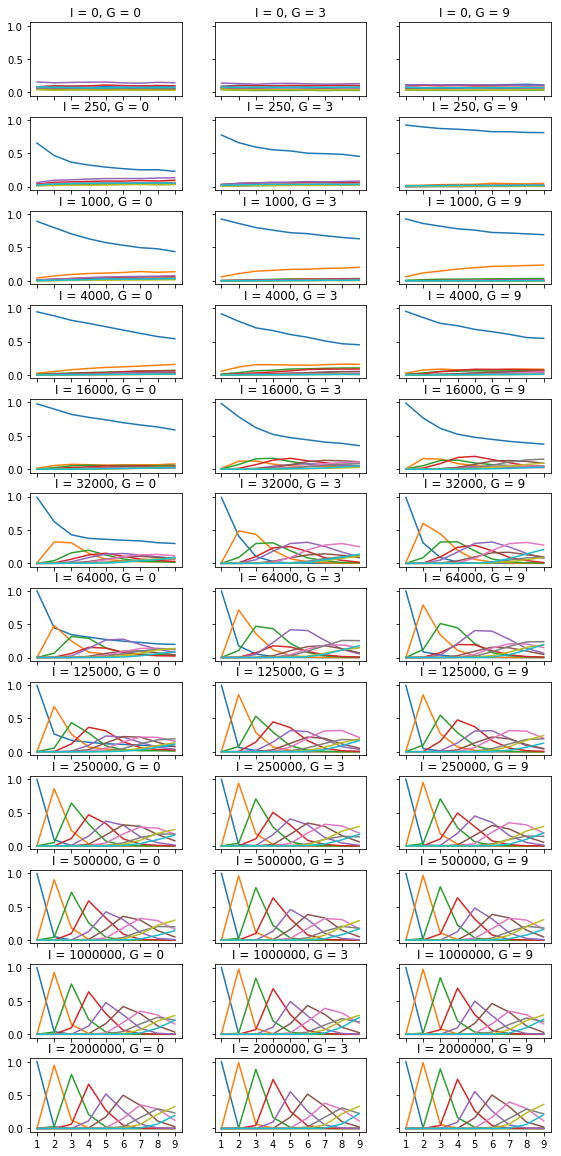

In [4]:
iter_idx = num_iters - 1
plot_hists(chist_mu,iter_idx)

## Run Linear Regression

In [5]:
import scipy.stats as st
import scipy.optimize as opt

def get_linreg(cvals,num_runs=10,eouts=range(1,10)):
    """Get lines of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    r_vals = np.zeros(num_runs)
    
    if num_runs is 1:
        aouts = np.array([cvals[eout-min_blobs] for eout in eouts])
        slopes, intercepts, r_vals, _, _ = st.linregress(eouts, aouts)
    else:
        for run in range(num_runs):
            aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
            slopes[run], intercepts[run], r_vals[run], _, _ = st.linregress(eouts, aouts)
    
    return slopes, intercepts, r_vals


def powfit(x, slope, intercept, power):
    y = slope * np.power(x, power) + intercept
    return y


def get_powreg(cvals,num_runs=10,eouts=range(1,10)):
    """Get power curve of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    powers = np.zeros(num_runs)
    
    for run in range(num_runs):
        aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
        popt, pcov = opt.curve_fit(powfit, eouts, aouts, [1,0,1], maxfev=2000)
        slopes[run], intercepts[run], powers[run] = popt

    return slopes, intercepts, powers

(10, 12, 3, 10)


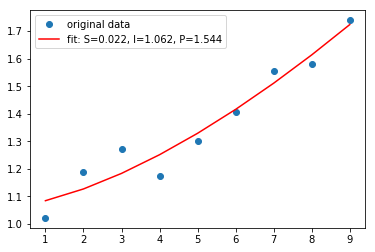

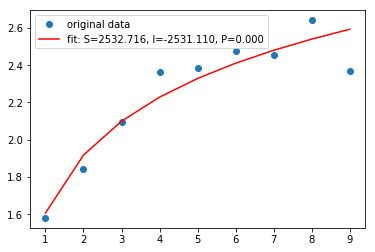

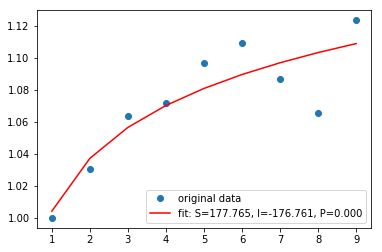

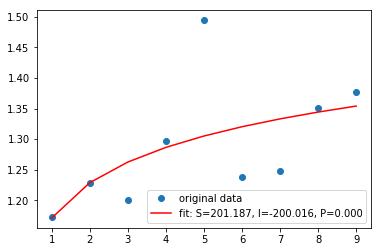

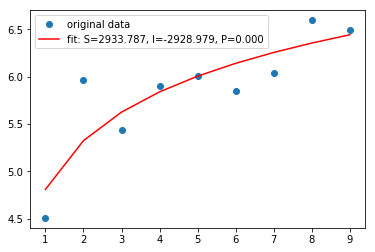

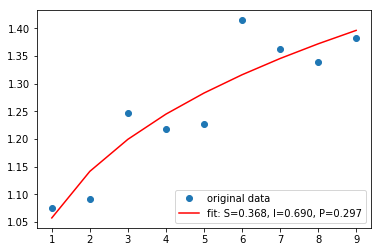

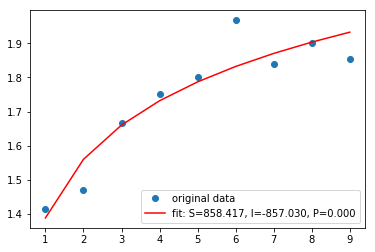

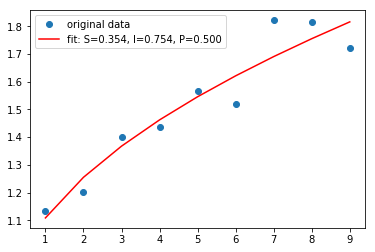

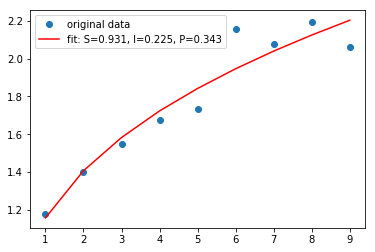

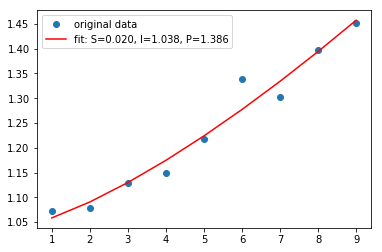

In [6]:
print(cmus.shape)

cmus_slopes, cmus_intercepts, cmus_rvals = get_linreg(cmus[:,11,2])
cmus_slopes_pow, cmus_intercepts_pow, cmus_power_pow = get_powreg(cmus[:,1,2])

csds_slopes, csds_intercepts, csds_rvals = get_linreg(csds[:,11,2])
ccvs_slopes, ccvs_intercepts, ccvs_rvals = get_linreg(ccvs[:,11,2])
ccvs_slopes_4to9, ccvs_intercepts_4to9, ccvs_rvals_4to9 = get_linreg(ccvs[:,11,2],eouts=range(4,10))
ccvs_slopes_4to9_mu, ccvs_intercepts_4to9_mu, ccvs_rvals_4to9_mu = get_linreg(ccvs_mu[11,2],num_runs=1,eouts=range(4,10))


# Visualize

# for i in range(num_runs):
#     plt.plot(range(1,10), cmus[i,11,2,:9], 'o', label='original data')
#     plt.plot(range(1,10), cmus_intercepts[i] + cmus_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()
    
for i in range(num_runs):
    plt.plot(range(1,10), cmus[i,1,2,:9], 'o', label='original data')
    plt.plot(range(1,10), powfit(range(1,10), cmus_slopes_pow[i], cmus_intercepts_pow[i], cmus_power_pow[i]), 'r-',
             label='fit: S=%5.3f, I=%5.3f, P=%5.3f' % (cmus_slopes_pow[i], cmus_intercepts_pow[i], cmus_power_pow[i]))
    plt.legend()
    plt.show()

# for i in range(num_runs):
#     plt.plot(range(1,10), csds[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), csds_intercepts[i] + csds_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()
    
# for i in range(num_runs):
#     plt.plot(range(1,10), ccvs[i,11,2,:9], 'o', label='original data')
#     plt.plot(range(1,10), ccvs_intercepts[i] + ccvs_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()

# for i in range(num_runs):
#     plt.plot(range(1,10), ccvs[i,11,2,:9], 'o', label='original data')
#     plt.plot(range(1,10), ccvs_intercepts_4to9[i] + ccvs_slopes_4to9[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()
    
# for i in range(num_runs):
#     plt.plot(range(1,10), ccvs_mu[11,2,:9], 'o', label='original data')
#     plt.plot(range(1,10), ccvs_intercepts_4to9_mu + ccvs_slopes_4to9_mu*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()

In [7]:
import math

def get_CI(vals):
    """Get the 95% confidence intervals."""

    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(9)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 4), round(hw, 4)

# Confidence Intervals

## Mean Choice

### Slope

In [8]:
get_CI(cmus_slopes)

(0.97899999999999998, 0.0177)

### Intercept

In [9]:
get_CI(cmus_intercepts)

(0.02, 0.037100000000000001)

### R-Values

In [10]:
get_CI(cmus_rvals)

(0.99970000000000003, 0.0001)

## Standard Deviation of Choice

### Slope

In [11]:
get_CI(csds_slopes)

(0.15939999999999999, 0.0073000000000000001)

### Intercept

In [12]:
get_CI(csds_intercepts)

(-0.15260000000000001, 0.018599999999999998)

### R-Values

In [13]:
get_CI(csds_rvals)

(0.98939999999999995, 0.0057999999999999996)

## Coefficient of Variation of Choice

### Slope

In [14]:
get_CI(ccvs_slopes)

(0.0149, 0.00080000000000000004)

### Intercept

In [15]:
get_CI(ccvs_intercepts)

(0.036999999999999998, 0.0061000000000000004)

### R-Values

In [16]:
get_CI(ccvs_rvals)

(0.79490000000000005, 0.032599999999999997)

# Final DRAM Chart

In [17]:
x = []
for i in range(12):
    x.append(range(0,10))
    
x
x = range(10)

In [25]:
def plot_graph(tstr, ax, col, ylim, cvals,
               show_S=False, show_I=False, show_band=False,
               show_linreg_eq=False, show_4to9_linreg_eq=False, plot_linreg=False, plot_4to9_linreg=False, powreg=False,
               all_iters_same_row=False):
    """Plot a single graph."""

    # take the averages across the 10 runs
    smu = np.mean(cvals,axis=0)
    smin = np.min(cvals,axis=0)
    smax = np.max(cvals,axis=0)
    
    if not all_iters_same_row:
        ax.set_title(ax.get_title() + tstr)
        
    ax.set_ylim(bottom=0,top=ylim)
    ax.set_xlim(left=0,right=10)
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_ticks_position('left')
            
    slopes, intercepts, rvals = get_linreg(cvals)
    S_mean, S_hw = get_CI(slopes)
    I_mean, I_hw = get_CI(intercepts)
    R_mean, R_hw = get_CI(rvals)
        
    if show_linreg_eq:

        ax.text(.25, .6, '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n $R: ' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        
    if show_S:
        tstr += "\nS=" + str(S_mean)
    
    if show_band:
        smin = np.insert(smin,0,None)
        smax = np.insert(smax,0,None)
        ax.fill_between(x,smin[:10],smax[:10], facecolor='orange')
        
       
    slopes, intercepts, rvals = get_linreg(cvals,eouts=range(4,10))
    S_mean, S_hw = get_CI(slopes)
    I_mean, I_hw = get_CI(intercepts)
    R_mean, R_hw = get_CI(rvals)
    
    if show_4to9_linreg_eq:
        ax.text(.75, .6, 'For numerosities 4 to 9:\n' + \
                '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n $R: ' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        
    
    if plot_4to9_linreg:
        ax.plot(range(1,10), I_mean + S_mean*range(1,10), 'r', label='fitted line')
        
    if show_I:
        tstr += "\nI=" + str(I_mean)

    if powreg:
        slopes, intercepts, powers = get_powreg(cvals)
        S_mean, S_hw = get_CI(slopes)
        I_mean, I_hw = get_CI(intercepts)
        P_mean, P_hw = get_CI(powers)
        
        ax.text(.75, .6, 'Power Law:\n' + \
                '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
                '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
                '$ \n $P: ' + str(P_mean) + ' \pm ' + str(P_hw) + '$',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        
        ax.plot(range(1,10), powfit(range(1,10), S_mean, I_mean, P_mean), 'r-')
        
    smu = np.insert(smu,0,None)
    ax.plot(x, smu[:10], '-', label=tstr, linewidth=2)
    
    
def plot_stats(cmus, csds, ccvs, all_iters, iter_indices, title=None, all_iters_same_row=False, show_CIs=False, show_band=False):
    """Make the table of graphs."""
    
    size = 4
    num_cols = 2
    
    if all_iters_same_row:
        num_rows = 1
    else:
        num_rows = len(iter_indices)
    
    fig, ax = plt.subplots(num_rows,num_cols,sharex=True, sharey=True,figsize=(size*num_cols,size*num_rows))
    plt.xticks(range(0,10))
    plt.xlabel("Stimulus Numerosity")
    
    
    if all_iters_same_row:
        title_ax = ax
        title_ax[0].set_title("Mean Choice")
        title_ax[1].set_title("Standard Deviation")
        title_ax[num_cols-1].set_title("Coefficient of Variation")
    else:
        title_ax = ax[0]
        title_ax[0].set_title("$\mathbf{Mean\ Choice}$\n\n")
        title_ax[1].set_title("$\mathbf{Standard\ Deviation}$\n\n")
        title_ax[num_cols-1].set_title("$\mathbf{Coefficient\ of\ Variation}$\n\n")
    
    if all_iters_same_row:
        ax1 = ax[0]
        ax2 = ax[num_cols-1].twinx()

        for i, iter_idx in enumerate(iter_indices):
            plot_graph("Iter: " + str(all_iters[iter_idx]), ax1, 0, 10, cmus[:,iter_idx], show_S=(True and not show_CIs), show_band=show_band, powreg=False, all_iters_same_row=True, show_linreg_eq=show_CIs)
            plot_graph("Iter: " + str(all_iters[iter_idx]), ax2, 2, 1, ccvs[:,iter_idx], show_I=(True and not show_CIs), show_band=show_band, plot_4to9_linreg=False, all_iters_same_row=True, show_4to9_linreg_eq=show_CIs)
#         ax1.legend(bbox_to_anchor=(0., -.22, 1., .102), loc=2, ncol=4, mode="expand", borderaxespad=0.)
        ax1.legend(ncol=2)
#         ax2.legend(bbox_to_anchor=(0., -.22, 1., .102), loc=2, ncol=4, mode="expand", borderaxespad=0.)
        ax2.legend(ncol=2)
    else:
        for i, iter_idx in enumerate(iter_indices):
            plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][0].twinx(), 0, 10, cmus[:,iter_idx], show_band=show_band, show_linreg_eq=show_CIs)
#             plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][1].twinx(), 1, 3, csds[:,iter_idx], show_CIs=show_CIs)
            plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][num_cols-1].twinx(), 2, .5, ccvs[:,iter_idx], show_band=show_band, show_4to9_linreg_eq=show_CIs)

    fig.tight_layout()
    
    if title is not None:
        fig.suptitle(title, fontsize=16)
        if num_rows is 10:
            top = .95
        elif num_rows is 4:
            top = .91
        else:
            top = .86
        fig.subplots_adjust(top=top)

    plt.show()

In [26]:
import csv


def make_vectors_csv(filename, cmus, ccvs, all_iters, iter_indices):
    """Make csv file containing slmean, slhw, icptmean, and icpthw values for some time points."""

    print(filename)
    with open(filename + '.csv', 'w') as csvfile:
        fieldnames = ["iter", "slope_mean", "slope_hw", "intercept_mean", "intercept_hw"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()

        for iter_idx in iter_indices:
            
            slopes, intercepts, rvals = get_linreg(cmus[:,iter_idx])
            S_mean, S_hw = get_CI(slopes)
            
            slopes, intercepts, rvals = get_linreg(ccvs[:,iter_idx],eouts=range(4,10))
            I_mean, I_hw = get_CI(intercepts)
            
            row = {
                'iter': all_iters[iter_idx],
                'slope_mean': S_mean,
                'slope_hw': S_hw,
                'intercept_mean': I_mean,
                'intercept_hw': I_hw
            }
            writer.writerow(row)
            
    print("Done making vectors csv file!")
    
    
def make_cmus_csv(filename, cmus, iter_idx):
    """Make a csv file with the mean choice values at a specific time point."""

    print(filename)
    with open(filename + '.csv', 'w') as csvfile:
        fieldnames = ["run"]
        for eout in range(1,10):
            fieldnames.append(eout)
                        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()
        
        for run in range(1,num_runs+1):
            row = { 'run': run }
            
            for eout in range(1,10):
                row[eout] = cmus[run-1][iter_idx][eout-1]
                
            writer.writerow(row)
            
    print("Done making cmus csv file!")

## View Many Iterations and Save CSV Files

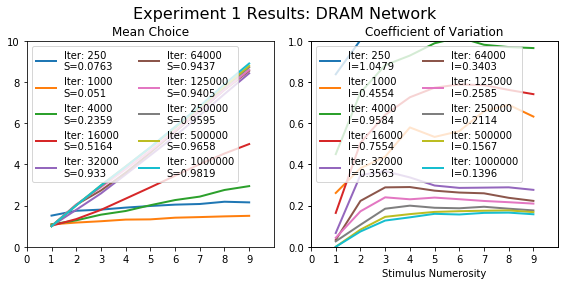

data/DRAM_classify_blobs_2/expt1draw
Done making vectors csv file!


In [27]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: DRAM Network", all_iters_same_row=True)
make_vectors_csv(data_directory + "expt1draw", cmus, ccvs, all_iters, iter_indices)

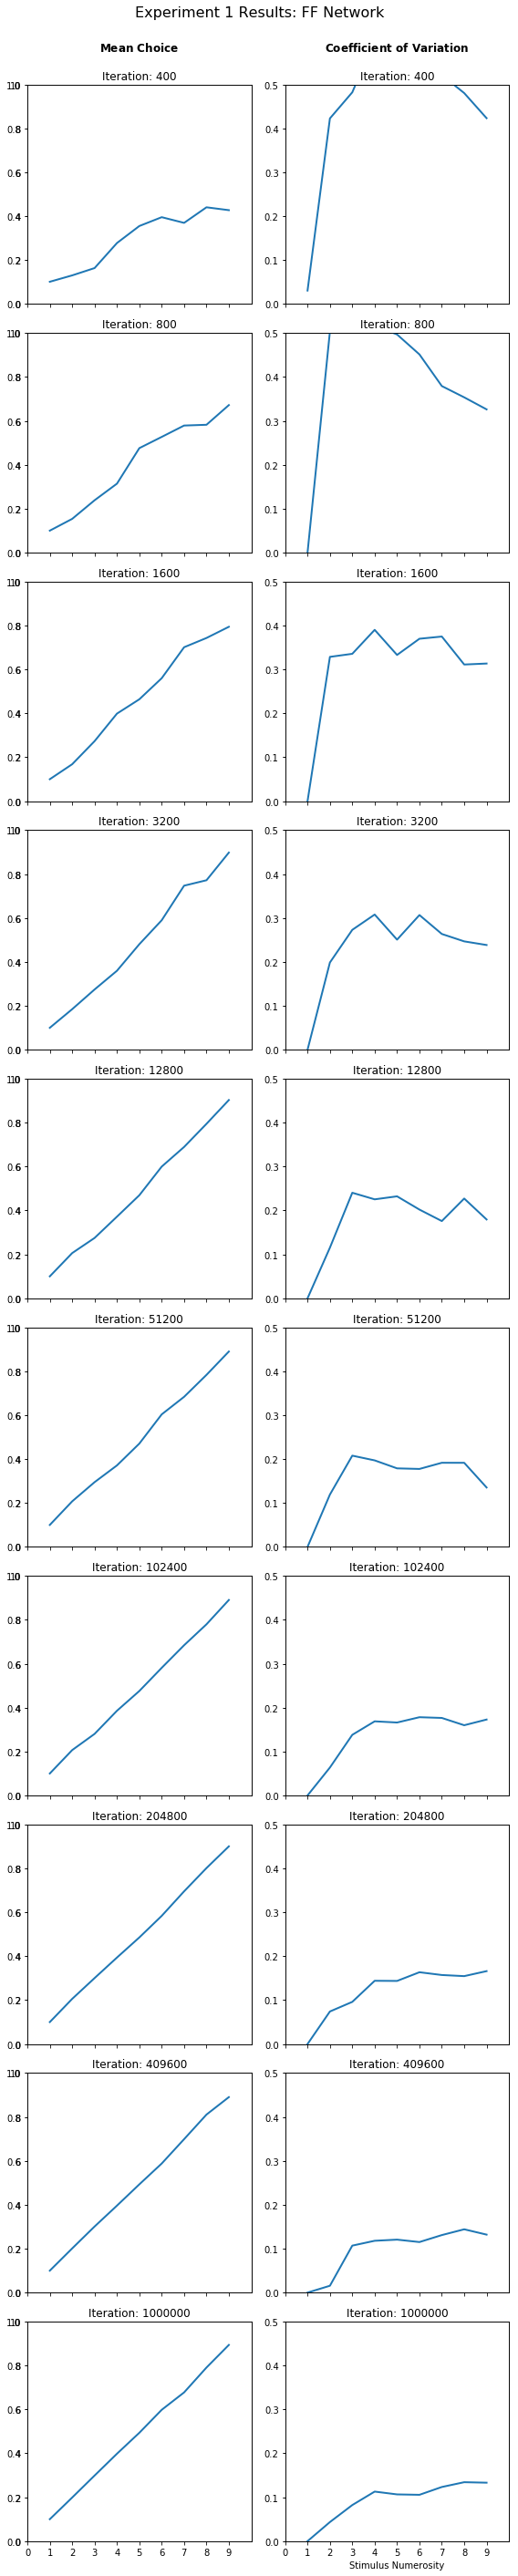

data/DRAM_onelayer/expt1ff
Done making vectors csv file!
data/DRAM_onelayer/expt1ff_cmus
Done making cmus csv file!


In [28]:
model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 800, 1600, 3200, 12800, 51200, 102400, 204800, 409600, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: FF Network")
make_vectors_csv(data_directory + "expt1ff", cmus, ccvs, all_iters, iter_indices)
make_cmus_csv(data_directory + "expt1ff_cmus", cmus, 1)

## View Essential Time Points

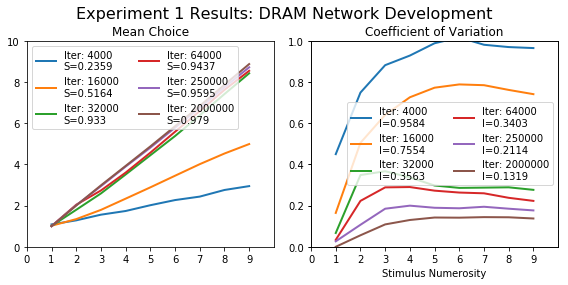

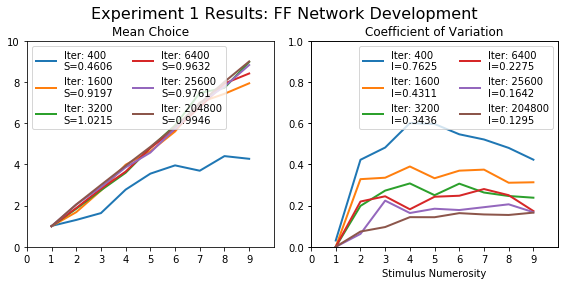

In [29]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [4000, 16000, 32000, 64000, 250000, 2000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: DRAM Network Development", all_iters_same_row=True)
model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 1600, 3200, 6400, 25600, 204800]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: FF Network Development", all_iters_same_row=True)

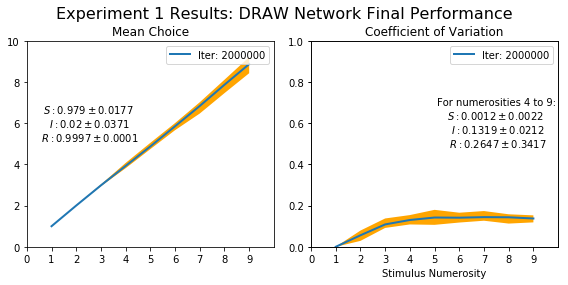

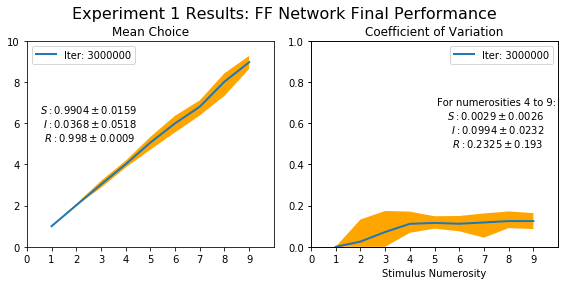

In [30]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [2000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: DRAW Network Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True)
model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [3000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: FF Network Final Performance", all_iters_same_row=True, show_CIs=True, show_band=True)

# Experiment 2

In [56]:
def plot_expt2_stats(model_name, test_group, title, iters):
    """Plot the experiment 2 results."""
    
    data_directory = "data/" + model_name + "/"
    
    all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
    iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
    
    if test_group is "fh" or test_group is "cta": # first half of test stimulus have constant total area
        cm = np.load(data_directory + 'choice_msdcv_fh.npy')[:,:,:10,:]
    elif test_group is "lh" or test_group is "caa": # last half of test stimulus have constant average area
        cm = np.load(data_directory + 'choice_msdcv_lh.npy')[:,:,:10,:]    
    elif test_group is "all":
        cm_fh = np.load(data_directory + 'choice_msdcv_fh.npy')[:,:,:10,:]
        cm_lh = np.load(data_directory + 'choice_msdcv_lh.npy')[:,:,:10,:]
        cm = (np.array(cm_fh) + np.array(cm_lh)) / 2.0
    
    cmus = cm[:,:,:,0] # mean
    csds = cm[:,:,:,1] # sd
    ccvs = cm[:,:,:,2] # cv
    
    show_CIs = len(iters) is 1
    plot_stats(cmus, csds, ccvs, all_iters, iter_indices, title, all_iters_same_row=True, show_CIs=show_CIs)

In [58]:
def create_expt2_panel(model_name, title, iters=[1000000]):
    """Create panel of all the expt 2 stats."""
    
    plot_expt2_stats(model_name, "all", title + ", Final Performance")
    plot_expt2_stats(model_name, "cta", title + ", CTA, Final Performance")
    plot_expt2_stats(model_name, "caa", title + ", CAA, Final Performance")
    
    plot_expt2_stats(model_name, "all", title + ", Development", iters=iters)
    plot_expt2_stats(model_name, "cta", title + ", CTA, Development", iters=iters)
    plot_expt2_stats(model_name, "caa", title + ", CAA, Development", iters=iters)

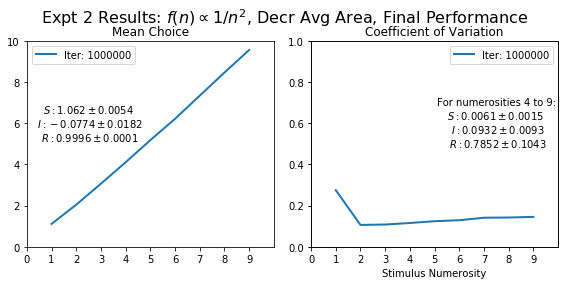

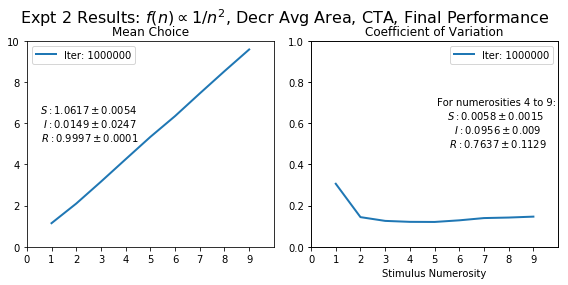

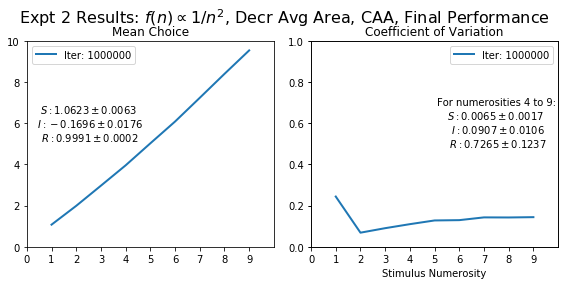

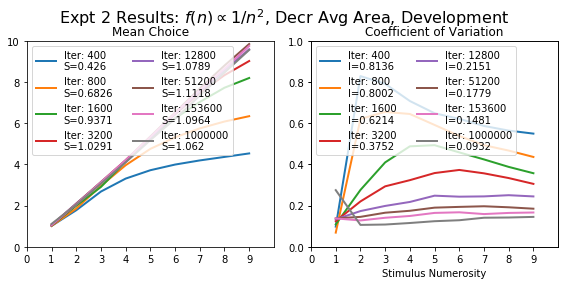

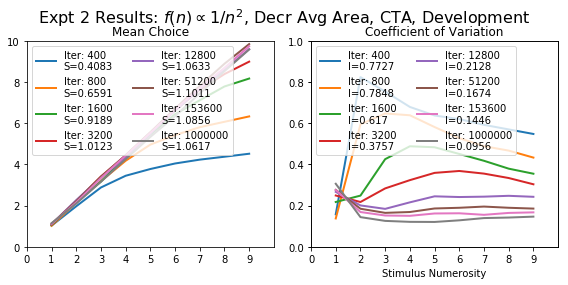

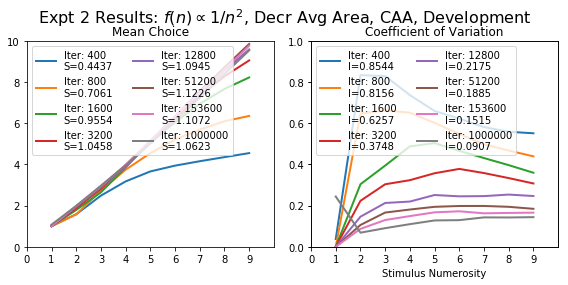

In [59]:
create_expt2_panel("DRAM_onelayer_data1", "Expt 2 Results: $f(n) \propto 1/n^2$, Decr Avg Area",
                   iters=[400, 800, 1600, 3200, 12800, 51200, 153600, 1000000])

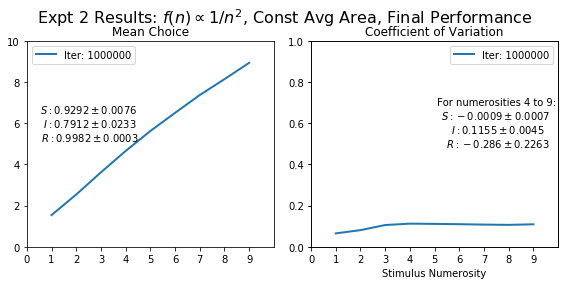

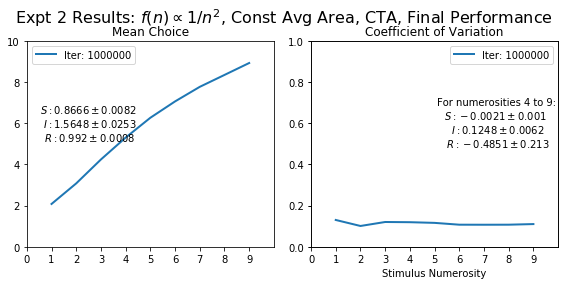

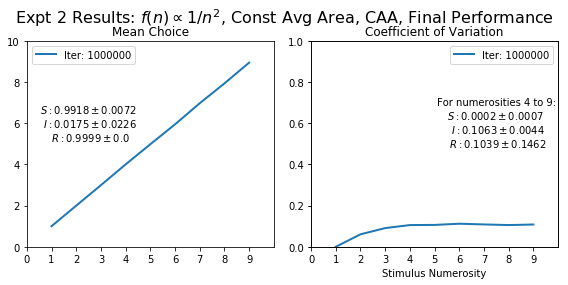

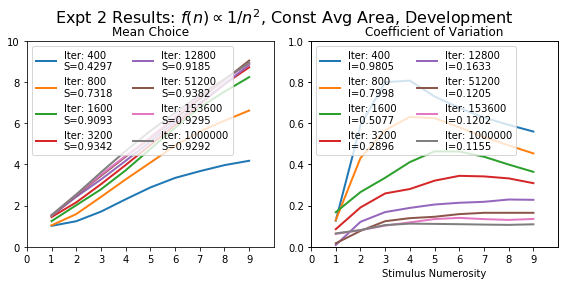

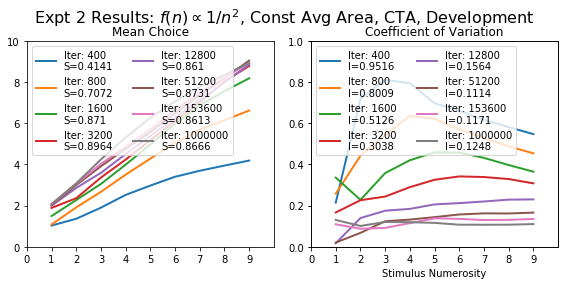

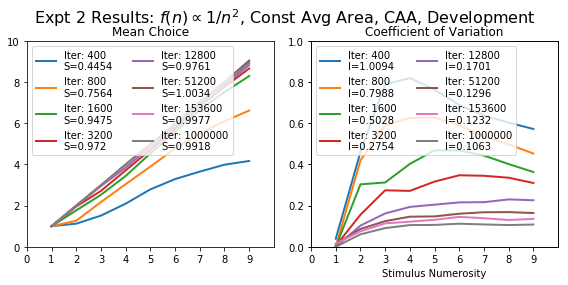

In [60]:
create_expt2_panel("DRAM_onelayer_data4", "Expt 2 Results: $f(n) \propto 1/n^2$, Const Avg Area",
                   iters=[400, 800, 1600, 3200, 12800, 51200, 153600, 1000000])

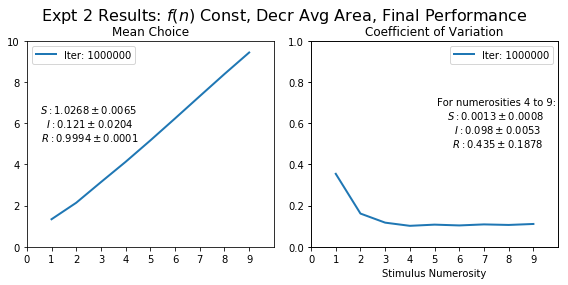

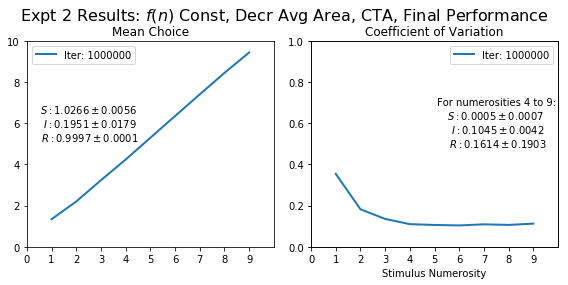

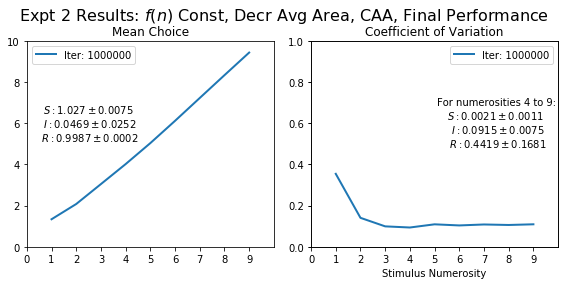

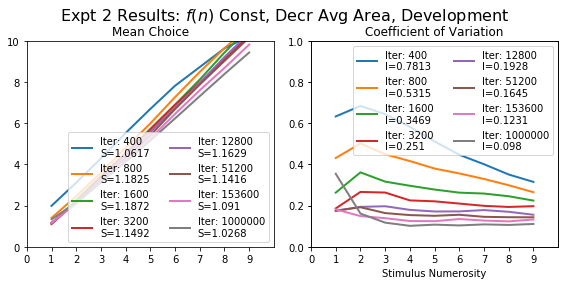

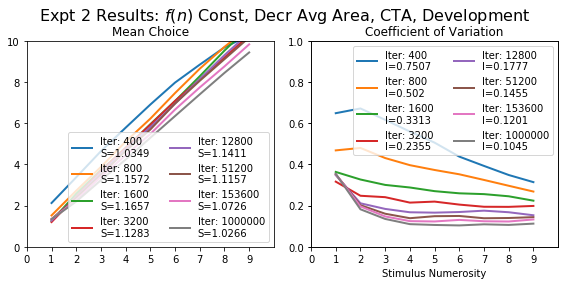

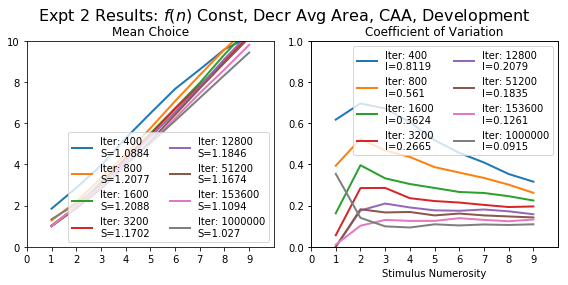

In [61]:
create_expt2_panel("DRAM_onelayer_data2", "Expt 2 Results: $f(n)$ Const, Decr Avg Area",
                   iters=[400, 800, 1600, 3200, 12800, 51200, 153600, 1000000])

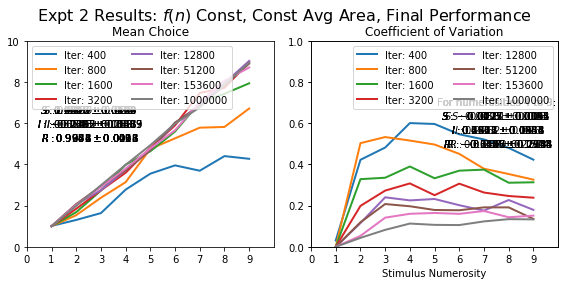

In [62]:
model_name = "DRAM_onelayer_data3"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 800, 1600, 3200, 12800, 51200, 153600, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Expt 2 Results: $f(n)$ Const, Const Avg Area, Final Performance", all_iters_same_row=True, show_CIs=True)

In [45]:
plot_expt2_stats("DRAM_onelayer_data3", "all", "Expt 2 Results: $f(n)$ Const, Const Avg Area, Final Performance")
plot_expt2_stats("DRAM_onelayer_data3", "cta", "Expt 2 Results: $f(n)$ Const, Const Avg Area, CTA, Final Performance")
plot_expt2_stats("DRAM_onelayer_data3", "caa", "Expt 2 Results: $f(n)$ Const, Const Avg Area, CAA, Final Performance")

FileNotFoundError: [Errno 2] No such file or directory: 'data/DRAM_onelayer_data3/choice_msdcv_fh.npy'

In [ ]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [4000, 16000, 32000, 64000, 250000, 2000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: DRAM Network Development", all_iters_same_row=True)